# ***Abstract :***
# This project is built to detect the depressive based on the tweet content user posted. 

# **Section 1: Load Data**

## Recommend using colab to run my program ##

In [40]:
! git clone https://github.com/Jingxuan-Bao/Tweet_Depression_Detection.git

fatal: destination path 'Tweet_Depression_Detection' already exists and is not an empty directory.


In [41]:
# read normal tweet data from my github

import pandas as pd

#normal_url = 'https://raw.githubusercontent.com/Jingxuan-Bao/Tweet_Depression_Detection/0da9d2cecce5884177f5715f9f148ffabcada064/dataset/normal_tweet.csv'
#normal_tweet = pd.read_csv(normal_url)
normal_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/normal_tweet.csv')
print(normal_tweet.head())

                                                text  label
0  in class. im EARLY. bummed RYAN SEACREST never...      0
1                                   i wanna go home       0
2                                  Our AC is broken       0
3  feels that the only place where Federer (&amp;...      0
4  @tommcfly Yeah tom, you are always the one tha...      0


In [42]:
#normal_tweet = normal_tweet.sample(n=6000, random_state=42)

In [43]:
normal_tweet

,text,label
0,in class. im EARLY. bummed RYAN SEACREST never...,0
1,i wanna go home,0
2,Our AC is broken,0
3,feels that the only place where Federer (&amp;...,0
4,"@tommcfly Yeah tom, you are always the one tha...",0
...,...,...
59995,It's 8:40am... I've been awake for nearly 2 ho...,0
59996,ughh mom`s making me cook dinner when i`m in t...,0
59997,"argh. netregistry is pissing me off today, pos...",0
59998,@gemmak500 It's amazing how many couples you s...,0


In [44]:
# read depressive tweet data from my github

col_names = ['text']

#depressive_url = 'https://raw.githubusercontent.com/Jingxuan-Bao/Tweet_Depression_Detection/0da9d2cecce5884177f5715f9f148ffabcada064/dataset/depressive_tweets_processed.csv'
#depressive_url = 'https://raw.githubusercontent.com/Jingxuan-Bao/Tweet_Depression_Detection/0da9d2cecce5884177f5715f9f148ffabcada064/dataset/depressive_tweets.csv'
#depressive_tweet = pd.read_csv(depressive_url, sep = '|', header = None, usecols = [5], nrows = 3600, names=col_names)
depressive_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/depressive_tweets.csv')
print(depressive_tweet.head())

   Unnamed: 0             tweet.id           created_at  \
0           0  1447537898572574730  2021-10-11 12:21:43   
1           1  1447540582490988553  2021-10-11 12:32:23   
2           2  1447807717859491842  2021-10-12 06:13:53   
3           3  1448076026219692033  2021-10-13 00:00:03   
4           4  1448382047375040513  2021-10-13 20:16:04   

                                                text          location  \
0  Open discussion. Between the Transfer Portal a...  Cheyenne Wyoming   
1  Plenty of things are changing in my life and t...               NaN   
2  I feel a little hopeless. Anyone else? #hopele...               NaN   
3  Which is more healthy? Hope, or hopelessness? ...        Denver, CO   
4  So someone tell me how do I get over #HOPELESS...    Portland Or .    

   retweet  favorite  
0        0         0  
1        0         0  
2        0         0  
3        0         0  
4        0         2  


In [45]:
depressive_tweet

,Unnamed: 0,tweet.id,created_at,text,location,retweet,favorite
0,0,1447537898572574730,2021-10-11 12:21:43,Open discussion. Between the Transfer Portal a...,Cheyenne Wyoming,0,0
1,1,1447540582490988553,2021-10-11 12:32:23,Plenty of things are changing in my life and t...,NaN,0,0
2,2,1447807717859491842,2021-10-12 06:13:53,I feel a little hopeless. Anyone else? #hopele...,NaN,0,0
3,3,1448076026219692033,2021-10-13 00:00:03,"Which is more healthy? Hope, or hopelessness? ...","Denver, CO",0,0
4,4,1448382047375040513,2021-10-13 20:16:04,So someone tell me how do I get over #HOPELESS...,Portland Or .,0,2
...,...,...,...,...,...,...,...
24142,24142,1459521498842992642,2021-11-13 14:00:16,Just got banned from a server F #sad,Jakarta Capital Region,0,1
24143,24143,1459521611997003777,2021-11-13 14:00:43,I literally cried during my exam and the cam i...,بيت أمك,0,0
24144,24144,1459524263946326017,2021-11-13 14:11:15,No one can be happy with a guy like me. That's...,"Varanasi, Uttar Pradesh, India",0,0
24145,24145,1459530315437785095,2021-11-13 14:35:18,arrived at my house but Am I Home? #deep #sad ...,they19sea,1,3


In [46]:
# preprocess the depressive tweet, extract the target content, clean null data

#depressive_tweet = depressive_tweet[depressive_tweet['text']]
depressive_tweet['label'] = 1
#depressive_tweet = depressive_tweet.dropna()
depressive_tweet = depressive_tweet[['text', 'label']]
depressive_tweet = depressive_tweet.dropna()

In [47]:
depressive_tweet

,text,label
0,Open discussion. Between the Transfer Portal a...,1
1,Plenty of things are changing in my life and t...,1
2,I feel a little hopeless. Anyone else? #hopele...,1
3,"Which is more healthy? Hope, or hopelessness? ...",1
4,So someone tell me how do I get over #HOPELESS...,1
...,...,...
24142,Just got banned from a server F #sad,1
24143,I literally cried during my exam and the cam i...,1
24144,No one can be happy with a guy like me. That's...,1
24145,arrived at my house but Am I Home? #deep #sad ...,1


# **Section 2: Data Processing**

## **Secion2.1: Clean Tweet**

In [48]:
# merge normal tweet and depressive tweet

df = pd.concat([normal_tweet,depressive_tweet])
# shuffle the data
df = df.sample(frac=1)

In [49]:
df

,text,label
20518,These poor babies probably have dirty diapers ...,0
743,Feeling #depressed,1
2170,@ddlovato HEY DEMI WHY DO YOU NOT COME TO AUST...,0
11351,Time to check in with yourself!\nLet’s make a ...,1
30921,Up early studying,0
...,...,...
26251,"Awake, and off to work... To bad I got no slee...",0
41964,@thegaydreamer I missed it do you know if the...,0
45513,@b4k4n3k0 i wish had some cool acronym diseases,0
48204,"Today, I tripped over my own big toe.",0


In [50]:
%pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
'''
#code here
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_tweet_text(tweet_text):
    # Conver to string 
    text = str(tweet_text)

    # Q4.1 Tokenize into single word units
    tokens = word_tokenize(text)

    #Q4.2 Reduce the case of each word
    tokens = [word.lower() for word in tokens]

    #Q4.3 Remove all stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #Q4.4 Stem each word
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    #return tokens
    return ' '.join(tokens)
'''

"\n#code here\nimport nltk \nfrom nltk.tokenize import word_tokenize\nfrom nltk.corpus import stopwords\nfrom nltk.stem import PorterStemmer\nnltk.download('stopwords')\nnltk.download('punkt')\n\ndef preprocess_tweet_text(tweet_text):\n    # Conver to string \n    text = str(tweet_text)\n\n    # Q4.1 Tokenize into single word units\n    tokens = word_tokenize(text)\n\n    #Q4.2 Reduce the case of each word\n    tokens = [word.lower() for word in tokens]\n\n    #Q4.3 Remove all stopwords\n    stop_words = set(stopwords.words('english'))\n    tokens = [word for word in tokens if word not in stop_words]\n\n    #Q4.4 Stem each word\n    stemmer = PorterStemmer()\n    tokens = [stemmer.stem(word) for word in tokens]\n\n    #return tokens\n    return ' '.join(tokens)\n"

In [52]:

import re
import string
import nltk
import contractions
#import emoji
nltk.download('stopwords')

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_tweet_text(tweet_text):
    # Conver to string 
    tweet_text = str(tweet_text)

    # Convert to lowercase
    tweet_text = tweet_text.lower()

    # Expand contractions
    tweet_text = contractions.fix(tweet_text)

    # Remove URLs
    tweet_text = re.sub(r"http\S+", "", tweet_text)

    # Remove mentions (@) and hashtags (#)
    tweet_text = re.sub(r'\@\w+|\#', '', tweet_text)

    # Remove emojis
    tweet_text = remove_emojis(tweet_text)

    # Remove punctuation
    tweet_text = tweet_text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    tweet_text = re.sub(r"\d+", "", tweet_text)

    # Remove whitespace
    tweet_text = tweet_text.strip()

    # Tokenize the text into individual words
    tweet_words = tweet_text.split()

    # Remove stop words using NLTK library
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tweet_words = [word for word in tweet_words if word not in stop_words]

    # Join the remaining words back into a string
    processed_tweet_text = " ".join(tweet_words)

    return processed_tweet_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
#df['text'] = df['text'].apply(preprocess_tweet_text)

In [54]:
df

,text,label
20518,These poor babies probably have dirty diapers ...,0
743,Feeling #depressed,1
2170,@ddlovato HEY DEMI WHY DO YOU NOT COME TO AUST...,0
11351,Time to check in with yourself!\nLet’s make a ...,1
30921,Up early studying,0
...,...,...
26251,"Awake, and off to work... To bad I got no slee...",0
41964,@thegaydreamer I missed it do you know if the...,0
45513,@b4k4n3k0 i wish had some cool acronym diseases,0
48204,"Today, I tripped over my own big toe.",0


## **Secion2.2: Word Analysis**

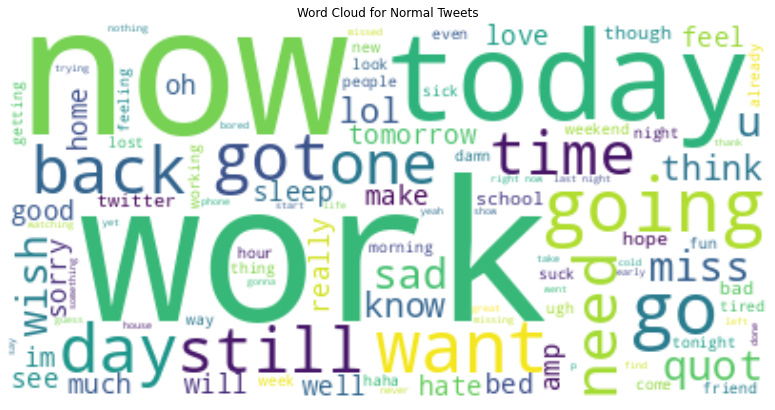

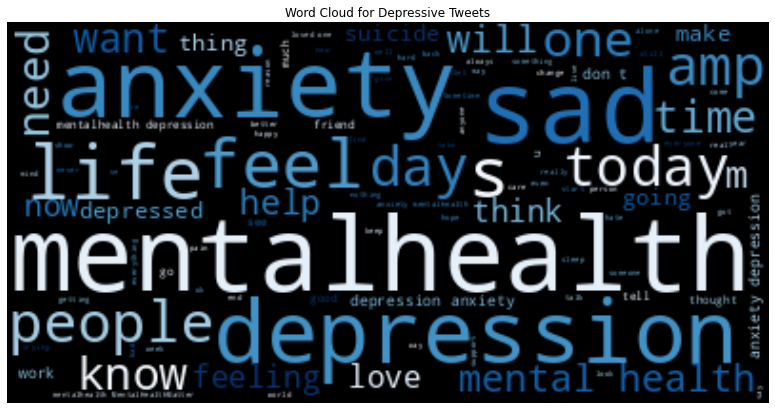

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(text, title):
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.title(title)
    plt.show()

def show_wordclou_depressive(text, title):
    wordcloud = WordCloud(max_words=100, colormap="Blues").generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.title(title)
    plt.show()


normal_tweets = df[df['label'] == 0]['text']
depressive_tweets = df[df['label'] == 1]['text']

normal_text = ' '.join(normal_tweets)
depressive_text = ' '.join(depressive_tweets)

show_wordcloud(normal_text, "Word Cloud for Normal Tweets")
show_wordclou_depressive(depressive_text, "Word Cloud for Depressive Tweets")

In [56]:
from collections import Counter
import itertools

normal_words = list(itertools.chain(*[tweet.split() for tweet in normal_tweets]))
depressive_words = list(itertools.chain(*[tweet.split() for tweet in depressive_tweets]))

normal_word_count = Counter(normal_words)
depressive_word_count = Counter(depressive_words)

print("Most common words in normal tweets:")
print(normal_word_count.most_common(10))
print("\nMost common words in depressive tweets:")
print(depressive_word_count.most_common(10))

Most common words in normal tweets:
[('to', 24095), ('I', 21480), ('the', 18051), ('a', 13507), ('my', 11946), ('i', 11535), ('and', 10749), ('is', 9311), ('in', 8404), ('for', 7152)]

Most common words in depressive tweets:
[('to', 17552), ('I', 14108), ('the', 13062), ('and', 11490), ('a', 11192), ('of', 8410), ('you', 8332), ('is', 8011), ('#mentalhealth', 6790), ('in', 6455)]


# **Section 3: Feature Extraction**

In [57]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Split the dataset
train_data, validation_data = train_test_split(df, test_size=0.2, random_state=42)

In [59]:
def calculate_proportions(data):
    len_rows = len(data)
    depressive_rows = len(data[data['label'] == 1])
    non_depressive_rows = len(data[data['label'] == 0])
    
    depressive_percentage = (depressive_rows / len_rows) * 100
    non_depressive_percentage = (non_depressive_rows / len_rows) * 100
    
    return depressive_percentage, non_depressive_percentage

train_depressive_percentage, train_normal_percentage = calculate_proportions(train_data)
validation_depressive_percentage, validation_normal_percentage = calculate_proportions(validation_data)

print(f"Development set: Depressive = {train_depressive_percentage:.2f}%, non-Depressive = {train_normal_percentage:.2f}%")
print(f"Validation set: Depressive = {validation_depressive_percentage:.2f}%, non-Depressive = {validation_normal_percentage:.2f}%")

Development set: Depressive = 28.79%, non-Depressive = 71.21%
Validation set: Depressive = 28.34%, non-Depressive = 71.66%


In [60]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
# Q4.5 Apply TF-IDF weighting
# Q4.6 Generate continuous bi-grams from the stemmed words
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_data['text'])
X_test_tfidf = vectorizer.transform(validation_data['text'])
'''

"\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n# Q4.5 Apply TF-IDF weighting\n# Q4.6 Generate continuous bi-grams from the stemmed words\nvectorizer = TfidfVectorizer()\nX_train_tfidf = vectorizer.fit_transform(train_data['text'])\nX_test_tfidf = vectorizer.transform(validation_data['text'])\n"

In [61]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
# Fit the vectorizer to the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer (do not fit the vectorizer on the test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
'''

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\n# Create a TF-IDF vectorizer\ntfidf_vectorizer = TfidfVectorizer(max_features=10000)\n# Fit the vectorizer to the training data and transform it\nX_train_tfidf = tfidf_vectorizer.fit_transform(X_train)\n\n# Transform the test data using the same vectorizer (do not fit the vectorizer on the test data)\nX_test_tfidf = tfidf_vectorizer.transform(X_test)\n'

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = CountVectorizer()
# Fit the vectorizer to the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer (do not fit the vectorizer on the test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [63]:
X_train_tfidf

<67317x65207 sparse matrix of type '<class 'numpy.int64'>'
	with 1020210 stored elements in Compressed Sparse Row format>

In [64]:
X_test_tfidf

<16830x65207 sparse matrix of type '<class 'numpy.int64'>'
	with 244213 stored elements in Compressed Sparse Row format>

In [65]:
! pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
# save tfidf
import joblib

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [67]:
! pip install files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
from google.colab import files

files.download('/content/tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
normal_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/normal_tweet.csv')
print(normal_tweet.head())

normal_tweet = normal_tweet.sample(n=6000, random_state=42)

col_names = ['text']

depressive_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/depressive_tweets_processed.csv', sep = '|', header = None, usecols = [5], nrows = 3600, names=col_names)
print(depressive_tweet.head())
depressive_tweet = depressive_tweet.dropna()
#depressive_tweet = depressive_tweet[depressive_tweet['text']]
depressive_tweet['label'] = 1
#depressive_tweet = depressive_tweet.dropna()


depressive_tweet = depressive_tweet[['text', 'label']]

df = pd.concat([normal_tweet,depressive_tweet])
# shuffle the data
df = df.sample(frac=1)

                                                text  label
0  in class. im EARLY. bummed RYAN SEACREST never...      0
1                                   i wanna go home       0
2                                  Our AC is broken       0
3  feels that the only place where Federer (&amp;...      0
4  @tommcfly Yeah tom, you are always the one tha...      0
                                                text
0  The lack of this understanding is a small but ...
1  i just told my parents about my depression and...
2  depression is something i don't speak about ev...
3  Made myself a tortilla filled with pb&j. My de...
4  @WorldofOutlaws I am gonna need depression med...


In [78]:
df

,text,label
44962,Uggggh.....my head hurts,0
0,The lack of this understanding is a small but ...,1
28076,Just finished Henry Hatsworth. Do I dare star...,0
50560,slept very well.take a shower now.have to do m...,0
46818,i feel bad.. im like passing out on the phone ...,0
...,...,...
790,"Mom's depression tied to kids' emotional, inte...",1
2331,"I want sleep, but I can't I don't know why",0
7162,Tired and have to wk tmrw,0
35663,@RiskyBusinessMB You guys should do your acost...,0


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
MAX_NUM_WORDS = 10000
corpus = df['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tdidf_tensor = tfidf.fit_transform(corpus)

In [88]:
tdidf_tensor.shape

(8313, 10000)

In [89]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tdidf_tensor, df['label'].values, test_size=0.3)

In [90]:
from sklearn.svm import SVC

baseline_model = SVC()
baseline_model.fit(x_train, y_train)

predictions = baseline_model.predict(x_test)

accuracy_score(y_test, predictions)

0.9923817161186849

In [91]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.98966   1.00000   0.99480      1819
           1    1.00000   0.97185   0.98573       675

    accuracy                        0.99238      2494
   macro avg    0.99483   0.98593   0.99026      2494
weighted avg    0.99246   0.99238   0.99235      2494



# **Section 4: Model Compare**

When selecting a model for your tweet classification task, it's a good idea to start with simple models and then gradually move to more complex ones if needed.

## **Secion4.1: Logistic Regression**


In [31]:
#X_train_lr = X_train_tfidf.todense()
#X_test_lr = X_test_tfidf.todense()
#X_train_lr = X_train_tfidf.toarray()
#X_test_lr = X_test_tfidf.toarray()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train a Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_tfidf)

# Evaluate the Logistic Regression model
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg, digits=5))

Logistic Regression
Accuracy: 0.9837789661319073
Classification Report:
               precision    recall  f1-score   support

           0    0.98691   0.99058   0.98874     12099
           1    0.97567   0.96639   0.97101      4731

    accuracy                        0.98378     16830
   macro avg    0.98129   0.97848   0.97987     16830
weighted avg    0.98375   0.98378   0.98376     16830



In [ ]:
normal_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/normal_tweet.csv')
print(normal_tweet.head())

normal_tweet = normal_tweet.sample(n=6000, random_state=42)

col_names = ['text']

depressive_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/depressive_tweets_processed.csv', sep = '|', header = None, usecols = [5], nrows = 3600, names=col_names)
print(depressive_tweet.head())
depressive_tweet = depressive_tweet.dropna()
#depressive_tweet = depressive_tweet[depressive_tweet['text']]
depressive_tweet['label'] = 1
#depressive_tweet = depressive_tweet.dropna()


depressive_tweet = depressive_tweet[['text', 'label']]

df = pd.concat([normal_tweet,depressive_tweet])
# shuffle the data
df = df.sample(frac=1)

X = df['text']
y = df['label']

X_tfidf = tfidf_vectorizer.transform(X)
y_pred_logreg = logreg.predict(X_tfidf)

# Evaluate the Logistic Regression model
print("Logistic Regression")
print("Accuracy:", accuracy_score(y, y_pred_logreg))
print("Classification Report:\n", classification_report(y, y_pred_logreg, digits=5))

                                                text  label
0  in class. im EARLY. bummed RYAN SEACREST never...      0
1                                   i wanna go home       0
2                                  Our AC is broken       0
3  feels that the only place where Federer (&amp;...      0
4  @tommcfly Yeah tom, you are always the one tha...      0
                                                text
0  The lack of this understanding is a small but ...
1  i just told my parents about my depression and...
2  depression is something i don't speak about ev...
3  Made myself a tortilla filled with pb&j. My de...
4  @WorldofOutlaws I am gonna need depression med...
Logistic Regression
Accuracy: 0.7288584145314567
Classification Report:
               precision    recall  f1-score   support

           0    0.72692   1.00000   0.84187      6000
           1    1.00000   0.02551   0.04975      2313

    accuracy                        0.72886      8313
   macro avg    0.86346   0.512

## **Secion4.2: KNN**

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Train a K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_tfidf)

# Evaluate the K-Nearest Neighbors model
print("K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn, digits=5))

K-Nearest Neighbors
Accuracy: 0.7846702317290553
Classification Report:
               precision    recall  f1-score   support

           0    0.76982   0.99926   0.86966     12099
           1    0.99200   0.23589   0.38115      4731

    accuracy                        0.78467     16830
   macro avg    0.88091   0.61757   0.62540     16830
weighted avg    0.83227   0.78467   0.73234     16830



## **Secion4.3: Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC

# Train a Support Vector Machines model
svm = SVC()
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate the Support Vector Machines model
print("Support Vector Machines")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm, digits=5))

Support Vector Machines
Accuracy: 0.9813428401663695
Classification Report:
               precision    recall  f1-score   support

           0    0.98988   0.98396   0.98691     12033
           1    0.96036   0.97478   0.96752      4797

    accuracy                        0.98134     16830
   macro avg    0.97512   0.97937   0.97721     16830
weighted avg    0.98147   0.98134   0.98138     16830



In [ ]:
normal_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/normal_tweet.csv')
#print(normal_tweet.head())

normal_tweet = normal_tweet.sample(n=6000, random_state=42)

col_names = ['text']

depressive_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/depressive_tweets_processed.csv', sep = '|', header = None, usecols = [5], nrows = 3600, names=col_names)
#print(depressive_tweet.head())
depressive_tweet = depressive_tweet.dropna()
#depressive_tweet = depressive_tweet[depressive_tweet['text']]
depressive_tweet['label'] = 1
#depressive_tweet = depressive_tweet.dropna()


depressive_tweet = depressive_tweet[['text', 'label']]

df = pd.concat([normal_tweet,depressive_tweet])
# shuffle the data
df = df.sample(frac=1)

X = df['text']
y = df['label']

X_tfidf = tfidf_vectorizer.transform(X)
y_pred_logreg = svm.predict(X_tfidf)

# Evaluate the Logistic Regression model
print("SVM")
print("Accuracy:", accuracy_score(y, y_pred_logreg))
print("Classification Report:\n", classification_report(y, y_pred_logreg, digits=5))

SVM
Accuracy: 0.9802718633465656
Classification Report:
               precision    recall  f1-score   support

           0    0.99092   0.98167   0.98627      6000
           1    0.95357   0.97665   0.96497      2313

    accuracy                        0.98027      8313
   macro avg    0.97224   0.97916   0.97562      8313
weighted avg    0.98052   0.98027   0.98034      8313



In [ ]:
tweet = 'The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It is soooo easy to compare. It is so easy to invalidate ourselves because of that.'

tweet = preprocess_tweet_text(tweet)

print('Input tweet : ', [tweet])


tweet_tfidf = tfidf_vectorizer.transform([tweet])

print('tweet tfidf : ', tweet_tfidf)

prediction = svm.predict(tweet_tfidf)

print(prediction)

Input tweet :  ['lack understanding small significant part causes anxiety depression feel incredibly lonely soooo easy compare easy invalidate']
tweet tfidf :    (0, 9269)	0.27157082782464403
  (0, 8127)	0.2515475399140283
  (0, 8006)	0.24589513243215994
  (0, 7895)	0.31649513475930513
  (0, 6310)	0.21964758174033866
  (0, 5109)	0.20291629499943586
  (0, 4827)	0.25895811155817705
  (0, 4347)	0.2875949417117318
  (0, 3197)	0.14838473086922194
  (0, 2742)	0.48739665925484327
  (0, 2302)	0.12039611046048009
  (0, 1751)	0.3148022187802479
  (0, 1392)	0.2755982878011113
  (0, 382)	0.11843010076527338
[1]


In [ ]:
# We choose SVM to make prediction

# save it 

#import joblib

# Save the trained SVM model
joblib.dump(svm, 'svm_model.pkl')

In [ ]:
files.download('/content/svm_model.pkl')

## **Secion4.4: Random Forests**

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forests model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate the Random Forests model
print("Random Forests")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=5))

Random Forests
Accuracy: 0.9765300059417706
Classification Report:
               precision    recall  f1-score   support

           0    0.97431   0.99355   0.98384     12099
           1    0.98264   0.93300   0.95717      4731

    accuracy                        0.97653     16830
   macro avg    0.97847   0.96327   0.97050     16830
weighted avg    0.97665   0.97653   0.97634     16830



In [ ]:
# We also save Random Forest to make prediction

# Save the trained rf model
joblib.dump(rf, 'rf_model.pkl')

In [ ]:
files.download('/content/rf_model.pkl')

## **Secion4.5: Deep Learning Model (LSTM)**



In [ ]:
!pip install tensorflow keras

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
import numpy as np
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100  # Maximum length of a sequence (you can adjust this value based on your dataset)
embedding_dim = 100  # Dimension of the GloVe embeddings

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_lstm_prob = model.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()

print("LSTM")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm, digits=5))

In [ ]:
joblib.dump(model, 'lstm_model.pkl')